# Transformer for Jet Classification

This task uses a different dataset. Each datapoint is 20 separate particles (a subset of the particles which make up the event).

In [1]:
import h5py
import numpy as np
from numpy.lib.recfunctions import structured_to_unstructured

In [2]:
import torch
print(torch.cuda.is_available())

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

False
Using cpu device


In [4]:
!wget -O part_transformer.h5 "https://cernbox.cern.ch/s/4rtGlo1RlFvUNwz/download/"

--2025-07-29 20:51:12--  https://cernbox.cern.ch/s/4rtGlo1RlFvUNwz/download/
Resolving cernbox.cern.ch (cernbox.cern.ch)... 128.142.53.35, 128.142.53.28, 137.138.120.151, ...
Connecting to cernbox.cern.ch (cernbox.cern.ch)|128.142.53.35|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/octet-stream]
Saving to: ‘part_transformer.h5’

part_transformer.h5     [         <=>        ] 333.07M  4.45MB/s    in 5m 14s  

2025-07-29 20:56:27 (1.06 MB/s) - ‘part_transformer.h5’ saved [349254496]



In [4]:
with h5py.File("part_transformer.h5","r") as f:
  signal_data = f["signal"][:]
  bkg_data = f["bkg"][:]

In [5]:
signal = structured_to_unstructured(signal_data)
background = structured_to_unstructured(bkg_data)

# Task starts here
* Concatenate the signal and background features into one array, and assign the appropriate target labels
* Split into training and testing datasets
* Scale the data ot some senisble scale
* Build a model which has 1) an MLP to embed the 5 features in some larger space 2) some transformer encoder layers 3) a pooling layer to condense the information in 1D format 4) a final MLP for the final classification
* Proceed with training (I only used the training dataset and used the test dataset solely for comparison at the end, with no validation dataset).

## Important
My transformer had 2 encoder layers with 2 attention heads, a batch size of 4096, a learning rate of 0.001, and trained for 20 epochs. It took about one minute per epoch to train. Making your transformer larger than this will increase the training time.

In [6]:
X = np.concatenate([signal,background])
X.shape #Already in the transformer shape we need i.e. Ndata x Ntokens x Nfeatures

(873126, 20, 5)

In [7]:
target = np.concatenate([np.ones(signal.shape[0]), np.zeros(background.shape[0])], axis=0)


In [8]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, target, test_size=0.15, random_state=42)

In [9]:
# Use sklearn standard scaler to scale the data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train.reshape(-1, 4))
X_scaled = scaler.transform(X_train.reshape(-1, 4))
X_scaled = X_scaled.reshape(X_train.shape)
X_test_scaled = scaler.transform(X_test.reshape(-1, 4))
X_test_scaled = X_test_scaled.reshape(X_test.shape)

In [10]:
X_train_tensor = torch.tensor(X_scaled,dtype=torch.float32,device=device)
X_test_tensor = torch.tensor(X_test_scaled,dtype=torch.float32,device=device)

Y_train_tensor = torch.tensor(Y_train.reshape(-1,1), dtype=torch.float32,device=device)
Y_test_tensor = torch.tensor(Y_test.reshape(-1,1), dtype=torch.float32,device=device)

In [11]:
import torch.nn as nn
import torch.nn.functional as F

class JetTransformer(nn.Module):

    """
    Transformer model for jet classification
    First step is an embedder for particles
    Next step is a set of transformer layers
    Last step is a classifier head
    """

    def __init__(self, input_dim, nhead, num_layers):
        super(JetTransformer, self).__init__()

        # Input embedding MLP
        self.input_embedder = nn.Sequential(
            nn.Linear(input_dim, 16),
            nn.ReLU(),
            nn.Linear(16, 32),
        )
        # Transformer Encoder - made of TransformerEncoderLayers
        self.transformer_encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=32, nhead=nhead,batch_first=True),
            num_layers=num_layers, enable_nested_tensor=False)

        # Output classifier MLP
        self.output_classifier_head = nn.Sequential(
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 1))

    def mean_pooling(self,x):
        """
        Mean pooling implementation
        """
        # x: (batch_size, num_tokens, embed_dim)
        return x.mean(dim=1)


    def forward(self, x):
        x = self.input_embedder(x)
        x = self.transformer_encoder(x)
        x = self.mean_pooling(x)
        x = self.output_classifier_head(x)
        return torch.sigmoid(x)

In [17]:
model = JetTransformer(input_dim=5, nhead=2, num_layers=2)
model = model.to(device)

In [18]:
# Load the train and test datasets in TensorDataset
from torch.utils.data import TensorDataset, DataLoader
train_dataset = TensorDataset(X_train_tensor, Y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, Y_test_tensor)
# Dataloaders
train_loader = DataLoader(train_dataset, batch_size=8192, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8192, shuffle=False)

In [19]:
# Define optimiser and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCELoss()


In [20]:
# Training loop with training data only
print("Beginning training loop")

train_losses = []
val_losses = []

num_epochs = 30
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)
    train_losses.append(avg_loss)
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_loss:.4f}")
    torch.cuda.empty_cache()

Beginning training loop
Epoch 1/30, Train Loss: 0.4316
Epoch 2/30, Train Loss: 0.3153
Epoch 3/30, Train Loss: 0.3055
Epoch 4/30, Train Loss: 0.3004
Epoch 5/30, Train Loss: 0.2971
Epoch 6/30, Train Loss: 0.2948
Epoch 7/30, Train Loss: 0.2927
Epoch 8/30, Train Loss: 0.2917
Epoch 9/30, Train Loss: 0.2913
Epoch 10/30, Train Loss: 0.2888
Epoch 11/30, Train Loss: 0.2887
Epoch 12/30, Train Loss: 0.2868
Epoch 13/30, Train Loss: 0.2842
Epoch 14/30, Train Loss: 0.2766
Epoch 15/30, Train Loss: 0.2660
Epoch 16/30, Train Loss: 0.2591
Epoch 17/30, Train Loss: 0.2525
Epoch 18/30, Train Loss: 0.2498
Epoch 19/30, Train Loss: 0.2465
Epoch 20/30, Train Loss: 0.2422


KeyboardInterrupt: 

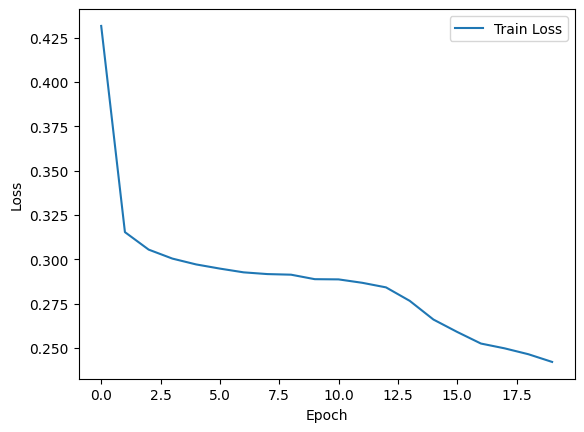

In [21]:
# Plot loss
import matplotlib.pyplot as plt
plt.plot(train_losses, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [22]:
# Evaluate by looping over the test_dataset
model.eval()
list_of_predictions = []
with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)  # if using GPU

        outputs = model(inputs)
        list_of_predictions.append(outputs)
        loss = criterion(outputs, targets)

In [23]:
pred = torch.concatenate(list_of_predictions)
Y_pred = torch.round(pred).detach().cpu().numpy()

from sklearn.metrics import roc_auc_score
print(roc_auc_score(Y_test.reshape(-1,1),Y_pred))

0.9024507452160863
